# Source localization with MNE/dSPM/sLORETA

The aim of this lecture is to teach you how to compute and apply
a linear inverse method such as MNE/dSPM/sLORETA on evoked/raw/epochs data.

`
Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
         Denis Engemann <denis.engemann@gmail.com>
`

In [1]:
%matplotlib qt
import matplotlib.pyplot as plt

import os
import numpy as np
import mne

mne.set_log_level('WARNING')

# Change the following path to where the folder ds000117-practical is on your disk
data_path = os.path.expanduser("~\\Downloads\\meeg\\ds000117-practical\\")  # this works and is user-independent

raw_fname = os.path.join(data_path,
    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif')

epochs_fname = raw_fname.replace('_meg.fif', '-epo.fif')

## Read epochs and compute ERP/ERF

In [2]:
epochs = mne.read_epochs(epochs_fname)
epochs

<EpochsFIF  |   144 events (all good), -0.5 - 2 sec, baseline [-0.2, 0], ~319.4 MB, data loaded,
 'face/famous/first': 24
 'face/famous/immediate': 10
 'face/famous/long': 14
 'face/unfamiliar/first': 25
 'face/unfamiliar/immediate': 11
 'face/unfamiliar/long': 10
 'scrambled/first': 25
 'scrambled/immediate': 14
 'scrambled/long': 11>

In [3]:
epochs.pick_types(meg=True, eeg=False)

<EpochsFIF  |   144 events (all good), -0.5 - 2 sec, baseline [-0.2, 0], ~259.9 MB, data loaded,
 'face/famous/first': 24
 'face/famous/immediate': 10
 'face/famous/long': 14
 'face/unfamiliar/first': 25
 'face/unfamiliar/immediate': 11
 'face/unfamiliar/long': 10
 'scrambled/first': 25
 'scrambled/immediate': 14
 'scrambled/long': 11>

In [4]:
evoked_face = epochs['face'].average()
evoked_scrambled = epochs['scrambled'].average()

In [5]:
contrast = mne.combine_evoked([evoked_face, evoked_scrambled], [0.5, -0.5])
contrast.crop(None, 0.2)  ## could specify -0.2 instead of None
contrast.plot();

In [6]:
contrast.plot_topomap(times=np.linspace(0.1, 0.2, 5), ch_type='mag');

## Compute noise covariance

See:

Engemann D.A., Gramfort A., Automated model selection in covariance estimation and spatial whitening of MEG and EEG signals, Neuroimage. 2015 Mar

In [7]:
noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0,  ## although tmax/min are set by default ...
                                   method=['shrunk', 'empirical'],  ## ...it's best to specify explicitly for speed
                                   rank='info')
print(noise_cov.data.shape)

(306, 306)


In [8]:
mne.viz.plot_cov(noise_cov, epochs.info)

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

# Show whitening

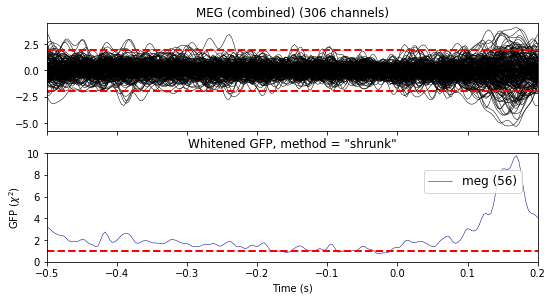

In [9]:
%matplotlib inline
contrast.plot_white(noise_cov);

## Using "empirical" only

In [10]:
noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0,  ## although tmax/min are set by default ...
                                   method='empirical',  ## ...it's best to specify explicitly for speed
                                   rank='info')
print(noise_cov.data.shape)

(306, 306)


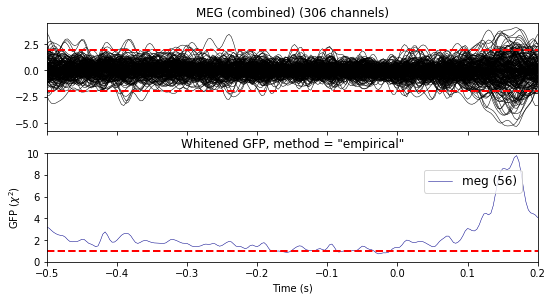

In [11]:
%matplotlib inline
contrast.plot_white(noise_cov);

...Doesn't seem to make a difference.

## Inverse modeling with MNE and dSPM on evoked and raw data

Import the required functions:

In [12]:
from mne.forward import read_forward_solution
from mne.minimum_norm import (make_inverse_operator, apply_inverse,
                              write_inverse_operator)

## Read the forward solution and compute the inverse operator

MNE/dSPM/sLORETA lead to linear inverse models that are independant
from the data (as they use just the noise covariance) and can therefore be
precomputed and applied to the data at a later stage.

In [13]:
fwd_fname = os.path.join(data_path,
    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01-meg-fwd.fif')
fwd = mne.read_forward_solution(fwd_fname)
fwd = mne.convert_forward_solution(fwd, surf_ori=True)

# Restrict forward solution as necessary for MEG
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# make an M/EEG, MEG-only, and EEG-only inverse operator
info = contrast.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2,  ## default value for surface-oriented source space; used as weight for tangential source var
                                         depth=0.8)  ## also default for surface-based methods

## Compute inverse solution / Apply inverse operators

In [14]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(contrast, inverse_operator, lambda2,
                    method=method, pick_ori=None)  ## pick_ori=None is default
print(stc)

<SourceEstimate  |  8188 vertices, subject : sub-01, tmin : -500.0 (ms), tmax : 200.00000000000006 (ms), tstep : 3.3333333333333335 (ms), data shape : (8188, 211)>


The ``stc`` (Source Time Courses) are defined on a source space formed by 8188 candidate
locations and for a duration spanning 121 time points. (Or 211 in our case.)

In [15]:
stc.save('fixed_ori')  # save the STC to disk

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compute source estimates using sLORETA or dSPM but without any orientation constraint (free orientation).</li>
    </ul>
</div>

## Show the result

In [19]:
subjects_dir = os.path.join(data_path, 'derivatives\\freesurfer-reconall\\')
subject = 'sub-01'

WARNING! The rest of this section cannot run in IPython architecture (Jupyter Notebook / Lab).

In [ ]:
brain = stc.plot(surface='inflated', hemi='both', subjects_dir=subjects_dir,
                 time_viewer=True)
brain.set_data_time_index(120)  ## this works with 211 anyway
brain.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain.show_view('ventral')
brain.save_image('dspm.jpg')

In [ ]:
from mayavi import mlab
mlab.close()

In [ ]:
from IPython.display import Image
Image(filename='dspm.jpg', width=600)

## Morphing data to an average brain for group studies

In [20]:
mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

'C:\\Users\\egora\\Downloads\\meeg\\ds000117-practical\\derivatives\\freesurfer-reconall\\fsaverage'

In [21]:
morph = mne.compute_source_morph(stc, subject_from=subject,
                                 subject_to='fsaverage',  ## this is a "template" surface image
                                 subjects_dir=subjects_dir)
stc_fsaverage = morph.apply(stc)

In [22]:
stc_fsaverage.save('fsaverage_dspm')

In [25]:
brain_fsaverage = stc_fsaverage.plot(surface='inflated', hemi='rh',
                                     subjects_dir=subjects_dir)
brain_fsaverage.set_data_time_index(45)
brain_fsaverage.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain_fsaverage.show_view('lateral')
brain_fsaverage.save_image('dspm_fsaverage.jpg')

colormap sequential: [8.00e+00, 1.20e+01, 1.50e+01] (transparent)


In [26]:
mlab.close()

In [ ]:
from IPython.display import Image
Image(filename='dspm_fsaverage.jpg', width=600)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Apply the inverse operator on 20s of raw data</li>   
      <li>Apply the inverse operator on individual epochs</li>   
      <li>Pick relevant label from a freesurfer parcellation and look at the label time course.</li>
    </ul>
</div>

In [31]:
raw = mne.io.read_raw_fif(raw_fname, preload=False)
print(raw)

<Raw  |  sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif, n_channels x n_times : 404 x 540100 (491.0 sec), ~7.4 MB, data not loaded>


In [40]:
evoked_fname = raw_fname.replace('_meg.fif', '-ave.fif')
evoked_fname
evoked = mne.read_evokeds(evoked_fname, baseline=(None, 0), proj=True)

In [32]:
from mne.minimum_norm import apply_inverse_raw, apply_inverse_epochs

start, stop = raw.time_as_index([0, 20])  # read the first 20s of data (at 1100 Hz, it's 22k samples)
# label = ...
# stc = apply_inverse_raw(raw, inverse_operator, lambda2, method, label,
#                        start, stop)

In [33]:
start

0

In [34]:
stop

22000

In [37]:
label = 'LOC'

And on epochs:

In [42]:
# Compute inverse solution and stcs for each epoch
# Use the same inverse operator as with evoked data (i.e., set nave)
# If you use a different nave, dSPM just scales by a factor sqrt(nave)

## nave = 1 (default): Number of averages used to regularize the solution

stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method, label,
                            pick_ori="normal", nave=1)  ## was: nave=evoked.nave

stc_evoked = apply_inverse(evoked, inverse_operator, lambda2, method,
                           pick_ori="normal")

stc_evoked_label = stc_evoked.in_label(label)

# Mean across trials but not across vertices in label
mean_stc = np.sum(stcs) / len(stcs)

AttributeError: 'str' object has no attribute 'hemi'

In [ ]:
# compute sign flip to avoid signal cancelation when averaging signed values
flip = mne.label_sign_flip(label, inverse_operator['src'])

label_mean = np.mean(mean_stc.data, axis=0)
label_mean_flip = np.mean(flip[:, np.newaxis] * mean_stc.data, axis=0)

# Average over label (not caring to align polarities here)
label_mean_evoked = np.mean(stc_evoked_label.data, axis=0)

View activation time-series to illustrate the benefit of aligning/flipping

In [ ]:
times = 1e3 * stcs[0].times  # times in ms

plt.figure()
h0 = plt.plot(times, mean_stc.data.T, 'k')
h1, = plt.plot(times, label_mean, 'r', linewidth=3)
h2, = plt.plot(times, label_mean_flip, 'g', linewidth=3)
plt.legend((h0[0], h1, h2), ('all dipoles in label', 'mean',
                             'mean with sign flip'))
plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.show()

## Exercises
- Run sLORETA on the same data and compare source localizations
- Run an LCMV beamformer on the same data and compare source localizations

### Going further:
- http://martinos.org/mne/dev/auto_examples/inverse/plot_compute_mne_inverse_epochs_in_label.html
- http://martinos.org/mne/dev/auto_examples/inverse/plot_label_source_activations.html
- http://martinos.org/mne/dev/auto_examples/inverse/plot_label_from_stc.html